In [2]:
!pip install mcap-ros2-support mcap


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import math

In [4]:
from mcap_ros2.decoder import DecoderFactory
from mcap.reader import make_reader

magnetometer_data = []
printer_data = []
with open(
    "../data/rosbag2_2024_01_11-11_38_41/rosbag2_2024_01_11-11_38_41_0.mcap",
    "rb",
) as fd:
    reader = make_reader(fd, decoder_factories=[DecoderFactory()])
    for schema, channel, message, ros_msg in reader.iter_decoded_messages(
    ):
        # print(f"{channel.topic} {schema.name} [{message.log_time}]: ")
        if channel.topic == "/magnetometer_reading":
            for reading in ros_msg.magnetic_field_array:
                timestamp = reading.header.stamp.sec + reading.header.stamp.nanosec * 1e-9
                magnetic_field_x = reading.magnetic_field.x
                magnetic_field_y = reading.magnetic_field.y
                magnetic_field_z = reading.magnetic_field.z
                magnetometer_data.append([timestamp, magnetic_field_x, magnetic_field_y, magnetic_field_z])

        elif channel.topic == "/tf":
            for transform in ros_msg.transforms:
                if transform.header.frame_id == "printer_head_link":
                    timestamp = transform.header.stamp.sec + transform.header.stamp.nanosec * 1e-9
                    x = transform.transform.translation.x
                    y = transform.transform.translation.y
                    z = transform.transform.translation.z
                    printer_data.append([timestamp, x, y, z])

<Figure size 500x400 with 0 Axes>

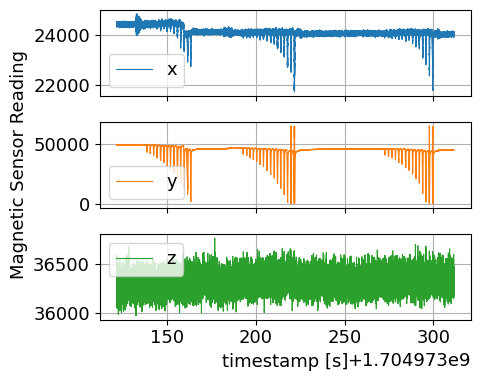

In [5]:
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns

plt.rcParams.update({"font.size": 13})

figsize = (5, 4)
output_dir = Path("../../reports/calibration_rig/figures")
plt.figure(figsize=figsize)

fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)

colors = sns.color_palette("tab10", 3)
for i, ax, label, c in zip(range(3), axes, ["x", "y", "z"], colors):
    ax.plot(
        [x[0] for x in magnetometer_data],
        [x[i + 1] for x in magnetometer_data],
        label=label,
        color=c,
        linewidth=.8,
    )
    if i == 1:
        ax.set_ylabel("Magnetic Sensor Reading")
    ax.grid()
    ax.legend()

plt.gca().set_xlabel("timestamp [s]")
plt.tight_layout()
plt.gcf().savefig(output_dir / "raw_magnetometer.png", bbox_inches="tight")

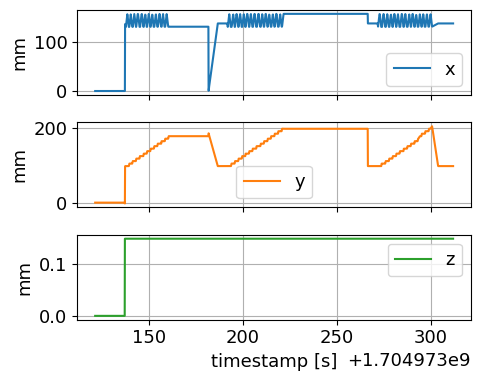

In [6]:
sns.set_palette("tab10")

# plt.figure(figsize=figsize)
fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)

colors = sns.color_palette("tab10", 3)
for i, ax, label, c in zip(range(3), axes, ["x", "y", "z"], colors):
    ax.grid()
    ax.plot(
        [x[0] for x in printer_data],
        [x[i + 1] for x in printer_data],
        label=label,
        color=c,
    )
    ax.legend()
    ax.set_ylabel("mm")

plt.gca().set_xlabel("timestamp [s]")
plt.tight_layout()
plt.savefig(output_dir / "3d_printer_raw.png", bbox_inches="tight")

In [7]:
import numpy as np
from scipy.signal import butter,filtfilt

# Filter requirements.
T = 5.0         # Sample Period
fs = 850       # sample rate, Hz
cutoff = 5     # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
# n = len(y_data) # total number of samples

def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # print(b.dtype, a.dtype)
    y = filtfilt(b, a, data)
    return y

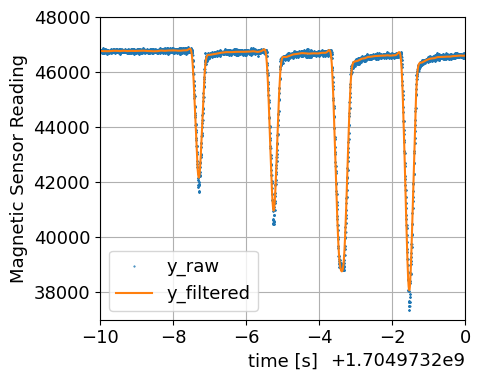

In [8]:
t_data = [x[0] for x in magnetometer_data]
y_data = [x[2] for x in magnetometer_data]

for i in range(len(y_data)):
    if y_data[i] > 50000:
        y_data[i] = y_data[i] - 2**16

y_filtered = butter_lowpass_filter(y_data, cutoff, fs, order)

plt.figure(figsize=figsize)
plt.plot(t_data, y_data, ".", ms=1, label="y_raw")
plt.plot(t_data, y_filtered, label="y_filtered")
plt.gca().set_xlabel("time [s]")
plt.gca().set_ylabel("Magnetic Sensor Reading")
plt.xlim([x + 1.704973e9 for x in (190, 200)])
plt.ylim([37000, 48000])
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(output_dir/ "filtered_magnetometer.png", bbox_inches="tight")

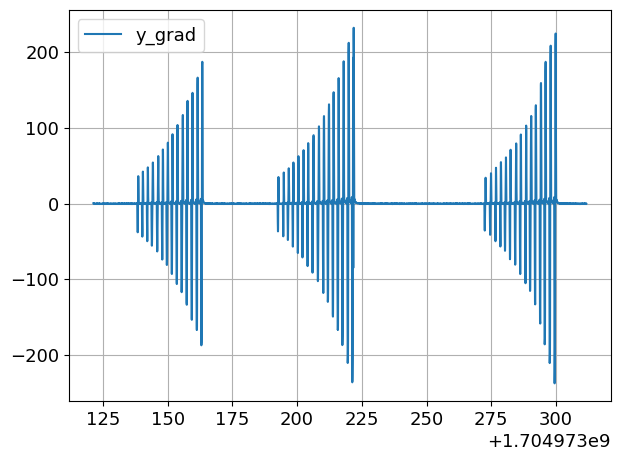

In [9]:
# get gradient of sensor data
import numpy as np

y_data = [float(x[2]) for x in magnetometer_data]
for i in range(len(y_data)):
    if y_data[i] > 55000:
        y_data[i] = y_data[i] - 2**16
y_filtered = butter_lowpass_filter(y_data, cutoff, fs, order)
y_grad = np.gradient(y_filtered)

plt.plot([x[0] for x in magnetometer_data], y_grad, label="y_grad")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("../../reports/ros_integration/figures/y_grad.png")


In [10]:
def split_into_episodes(y_grad, t_data):
    episodes = []
    open_episode = True
    episode_start = 0


    print(len(y_grad), len(t_data))
    for idx, pt in enumerate(y_grad):
        if open_episode:
            if pt < -10:
                # found start of episode
                open_episode = False
                episode_start = t_data[idx]
            else:
                continue
        else:
            if pt > 10:
                # found end of episode
                open_episode = True
                episodes.append((episode_start, t_data[idx]))
            else:
                continue
    return episodes

t_data = [x[0] for x in magnetometer_data]
episodes = split_into_episodes(y_grad, t_data)

169063 169063


/Users/liyouzhou/.pyenv/versions/3.10.13/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/liyouzhou/.pyenv/versions/3.10.13/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


46
[144.10500000000002, 137.445, 130.78, 124.105, 117.455, 110.75, 104.10000000000001, 97.41999999999999, 90.75500000000001, 84.09500000000001, 77.44, 70.75999999999999, 63.94, 63.94, 144.115, 137.44, 130.78, 124.11, 117.44, 110.78500000000001, 104.11000000000001, 97.455, 90.78500000000001, 84.09, 77.44500000000001, 70.76, 64.09500000000001, 57.44999999999999, 50.765, 44.105000000000004, nan, 144.13, 137.47, 130.775, 124.105, 117.46, 110.78, 104.12, 97.44, 90.76, 84.105, 77.44, 65.99000000000001, 57.43000000000001, 50.765, 44.09]
[-37.722881462908845, -43.450720662502135, -49.524387731366005, -55.43047778975233, -63.048672872046154, -73.76938856946435, -80.9771136010313, -92.83408591478292, -106.1440895582491, -116.90422140926239, -133.53397459086955, -153.40242484247938, -166.86591889249212, -187.11405573363118, -36.51863072087508, -43.05953214932015, -47.91386651778885, -56.63815426142173, -65.13632394603337, -70.9618359249107, -82.40259554014847, -91.09326617616898, -102.33808650411

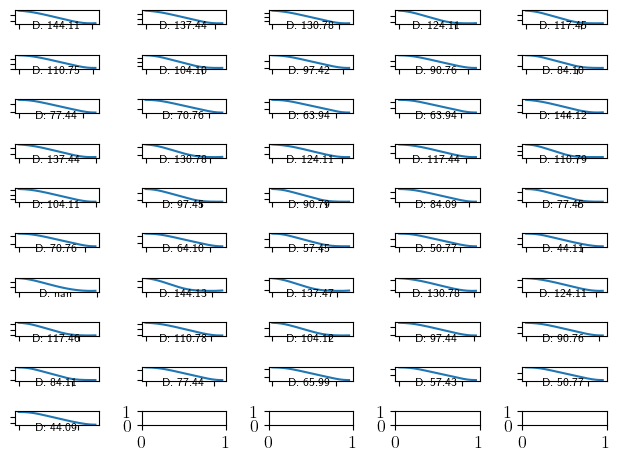

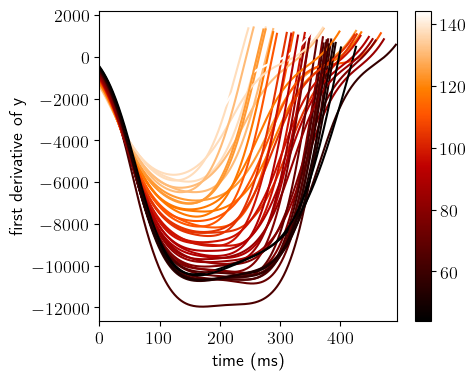

In [127]:

BEAM_EDGE_Y_RELATIVE_TO_NOZZLE = 56.75
WHISKER_TIP_Y = 35  # from the base of the printer bed


def distance_on_shaft(y):
    return 150 - (y - BEAM_EDGE_Y_RELATIVE_TO_NOZZLE - WHISKER_TIP_Y)


def get_episode_data(episodes, printer_data, y_filtered, t_data, y_grad):
    shaft_timestamp = [x[0] for x in printer_data]
    shaft_data = [distance_on_shaft(x[2]) for x in printer_data]

    shaft_data_zipped = list(zip(shaft_timestamp, shaft_data))
    shaft_data_per_episode = []

    episodes_data = []
    episodes_grad_data = []
    for episode_start, episode_end in episodes:
        episodes_data.append(
            [y for t, y in zip(t_data, y_filtered) if t >= episode_start and t <= episode_end]
        )
        shaft_data_per_episode.append(
            [
                x[1]
                for x in shaft_data_zipped
                if x[0] >= episode_start and x[0] <= episode_end
            ]
        )
        episodes_grad_data.append(
            [y for t, y in zip(t_data, y_grad) if t >= episode_start and t <= episode_end]
        )

    shaft_distance_per_episode = [float(np.median(x)) for x in shaft_data_per_episode]

    return episodes_data, episodes_grad_data, shaft_distance_per_episode

episodes_data, episodes_grad_data, shaft_distance_per_episode = get_episode_data(episodes, printer_data, y_filtered, t_data, y_grad)
print(len(episodes_data))
fig, axes = plt.subplots(ncols=5, nrows=math.ceil(len(episodes) / 5))
for idx, data in enumerate(episodes_data):
    ax = axes[idx // 5, idx % 5]
    ax.plot(data)
    ax.set_title(
        f"D: {shaft_distance_per_episode[idx]:.2f}", y=1.0, pad=-14, fontsize=8
    )

    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
plt.tight_layout()
plt.savefig("../../reports/ros_integration/figures/episodes_y_data.png")

# fig, axes = plt.subplots(ncols=5, nrows=math.ceil(len(episodes) / 5))
# for idx, data in enumerate(episodes_grad_data):
#     ax = axes[idx // 5, idx % 5]
#     ax.plot(data)
#     ax.set_title(f"D: {shaft_distance_per_episode[idx]:.2f}")

#     ax.axes.xaxis.set_ticklabels([])
#     ax.axes.yaxis.set_ticklabels([])
import matplotlib as mpl
import matplotlib.cm as cm

norm = mpl.colors.Normalize(
    vmin=min(shaft_distance_per_episode), vmax=max(shaft_distance_per_episode)
)
cmap = cm.gist_heat
x = 0.3

m = cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure(figsize=figsize)
for idx, data in enumerate(episodes_grad_data):
    d = shaft_distance_per_episode[idx]
    plt.plot(
        np.array(list(range(len(data))))/800 * 1000,
        [data*d for data in data],
        label=f"{d:.2f}",
        color=m.to_rgba(d),
    )

plt.xlim([0, max([len(x) for x in episodes_grad_data])/800 * 1000])
plt.rcParams['text.usetex'] = True
plt.gca().set_xlabel("time (ms)")
plt.gca().set_ylabel("first derivative of y")
plt.colorbar(m, ax=plt.gca())
plt.tight_layout()
plt.savefig(output_dir / "corrected_derivative.png", bbox_inches="tight")

max_grad_per_episode = [np.min(x) for x in episodes_grad_data]
print(shaft_distance_per_episode)
print(max_grad_per_episode)

46 46
50


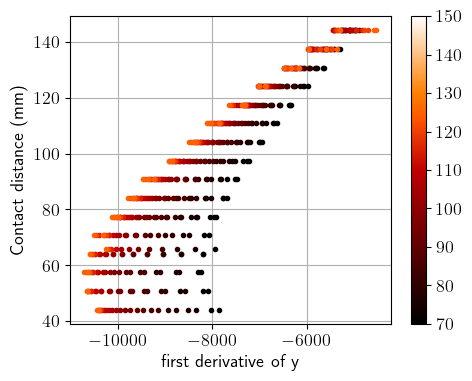

In [54]:
tenth_grad_per_episode = [x[10] for x in episodes_grad_data]

print(len(shaft_distance_per_episode), len(tenth_grad_per_episode))

norm = mpl.colors.Normalize(vmin=70, vmax=150)
cmap = cm.gist_heat
m = cm.ScalarMappable(norm=norm, cmap=cmap)

filtered_episodes_grad_data = []
filtered_shaft_distance_per_episode = []
for grad, dist in zip(episodes_grad_data, shaft_distance_per_episode):
    if len(grad) > 150 and (min(grad) * dist) > -11900 and not np.isnan(dist):
        filtered_episodes_grad_data.append(grad)
        filtered_shaft_distance_per_episode.append(dist)


print(min(len(x) for x in episodes_grad_data))
plt.figure(figsize=figsize)
for n in range(70, 130, 5):
    nth_grad_per_episode = [x[n] for x in filtered_episodes_grad_data]
    zipped_nth_grad_per_episode = zip(
        nth_grad_per_episode, filtered_shaft_distance_per_episode.copy()
    )
    zipped_nth_grad_per_episode = sorted(
        zipped_nth_grad_per_episode, key=lambda x: x[1]
    )
    plt.plot(
        [x * d for x, d in zipped_nth_grad_per_episode],
        [d for _, d in zipped_nth_grad_per_episode],
        ".",
        color=m.to_rgba(n),
    )

plt.colorbar(m, ax=plt.gca())
plt.xlabel("first derivative of y")
plt.ylabel("Contact distance (mm)")
plt.grid()
plt.tight_layout()
plt.savefig(output_dir / "x_y_relationship.png", bbox_inches="tight")

test rmse: 4.362307672281596
train rmse: 5.313238212212937
data rmse: 5.092180994593723
max_error 17.3794817049027


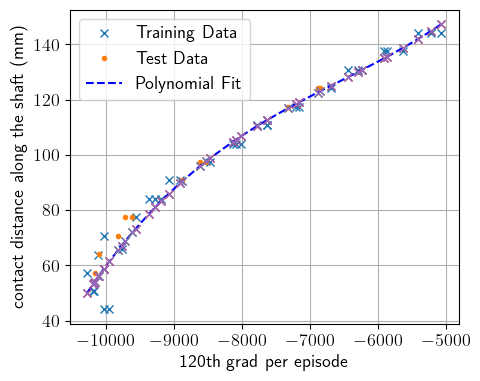

In [129]:
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split


def whisker_model(x, a, b, c, d):
    return a * x * x * x + b * x * x + c * x + d


def get_nth_grad_data(n):
    nth_grad_per_episode = [x[min(n, len(x) - 1)] for x in filtered_episodes_grad_data]
    zipped_nth_grad_per_episode = zip(
        nth_grad_per_episode, filtered_shaft_distance_per_episode.copy()
    )
    zipped_nth_grad_per_episode = [
        x for x in zipped_nth_grad_per_episode if not np.isnan(x[1])
    ]
    zipped_nth_grad_per_episode = sorted(
        zipped_nth_grad_per_episode, key=lambda x: x[1]
    )

    return zipped_nth_grad_per_episode


n = 100
m = 100
x_data = [x * d for x, d in get_nth_grad_data(n)]
y_data = [d for x, d in get_nth_grad_data(n)]

x1_data = [x * d for x, d in get_nth_grad_data(m)]
y1_data = [d for x, d in get_nth_grad_data(m)]

# plt.plot(np.array(x_data) - np.array(x1_data), y_data, "x")

# using the train test split function
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, random_state=104, test_size=0.25, shuffle=True
)
param, param_cov = curve_fit(whisker_model, x_train, y_train)

plt.figure(figsize=figsize)
plt.plot(x_train, y_train, "x", label="Training Data")
plt.plot(x_test, y_test, ".", label="Test Data")

plt.grid()

ans = [whisker_model(x, *param) for x in sorted(x_data)]

plt.plot(sorted(x_data), ans, "--", color="blue", label="Polynomial Fit")
plt.gca().set(
    xlabel="120th grad per episode", ylabel="contact distance along the shaft (mm)"
)
plt.legend()
plt.tight_layout()
plt.savefig(output_dir / "polynomial_regression.png", bbox_inches="tight")

def pred_rmse(x, y):
    test_pred = np.array([whisker_model(a, *param) for a in x])
    rmse = np.sqrt(np.mean((y - test_pred) ** 2))
    return rmse, test_pred

# calculate the root mean squared error
rmse, test_pred = pred_rmse(x_test, y_test)
plt.plot(x_test, test_pred, "x")
print(f"test rmse: {rmse}")

rmse, test_pred = pred_rmse(x_train, y_train)
plt.plot(x_train, test_pred, "x")
print(f"train rmse: {rmse}")

rmse, test_pred = pred_rmse(x_data, y_data)
plt.plot(x_data, test_pred, "x")
print(f"data rmse: {rmse}")

print("max_error", (np.max(np.abs(test_pred - y_data))))


Training process has finished.
[[-10.213039581773046, -10.596481557877269, -10.985868467327236, -11.38094384361466, -11.781386308124638, -12.186859647601523, -12.59706416508925, -13.011740998899768, -13.430633843981923, -13.853439871894807, -14.279774002996419, -14.709168117467925, -15.141102172194223, -15.57503957080553, -16.0104487023018, -16.44680213143147, -16.883565168300265, -17.32020578895026, -17.7562205404829, -18.191133726355474, -18.62447669867106, -19.055803615428886, -19.48473537921018, -19.91095883232265, -20.334180275549443, -20.754104370134883, -21.170448574885086, -21.58294236247093, -21.99131115712953, -22.39529563405449, -22.794696346292767, -23.189372970737168, -23.57919286456672, -23.963989023315662, -24.343548093544086, -24.717624123157293, -25.085996893787524, -25.448544498547562, -25.8052428877927, -26.156094483390916, -26.50107617300455, -26.840132354296657, -27.17317429093964, -27.500083388549683, -27.82075234495278, -28.135143289066036, -28.443287182279164, -

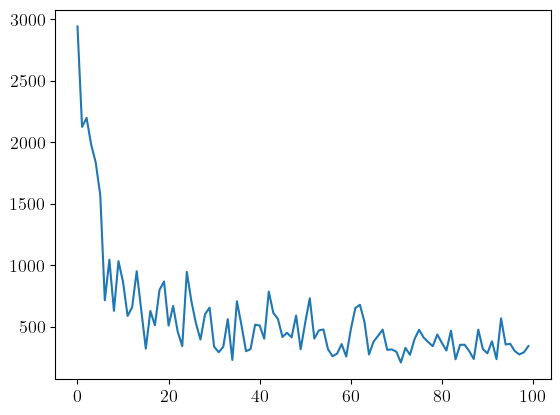

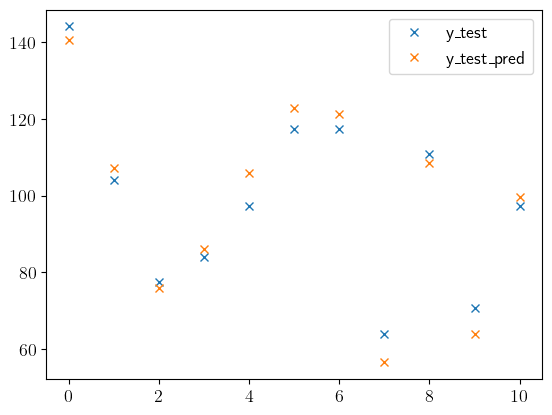

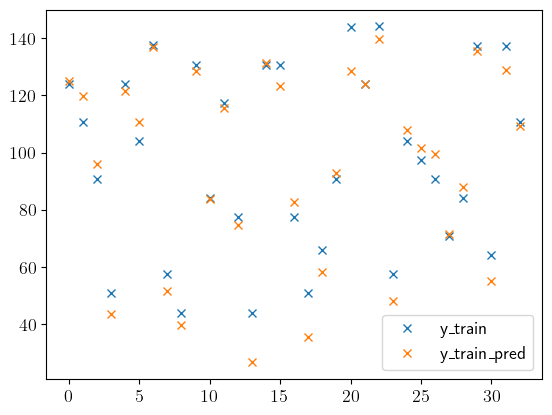

In [120]:
import torch
import torch.nn as nn

input_dim = 150
model = nn.Sequential()
model.add_module("dense1", nn.Linear(input_dim, 128, dtype=torch.float32))
model.add_module('act1', nn.ReLU())
model.add_module("dense2", nn.Linear(128, 64))
model.add_module('act2', nn.ReLU())
model.add_module("linear2", nn.Linear(64, 8))
model.add_module('act3', nn.ReLU())
model.add_module("output1", nn.Linear(8, 1))

loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


x_train, x_test, y_train, y_test = train_test_split(
    filtered_episodes_grad_data,
    filtered_shaft_distance_per_episode,
    random_state=104,
    test_size=0.25,
    shuffle=True,
)

losses = []
# Run the training loop
for epoch in range(100):  # 5 epochs at maximum

    # Print epoch
    # print(f"Starting epoch {epoch+1}")

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, (inputs, targets) in enumerate(zip(x_train, y_train)):
        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        torch_inputs = torch.tensor(np.array(inputs[:input_dim], dtype=np.float32))
        outputs = model(torch_inputs)

        # Compute loss
        torch_targets = torch.tensor(targets, dtype=torch.float32)
        loss = loss_fn(outputs, torch_targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        # if i % 10 == 4:
            # print("Loss after mini-batch %5d: %.3f" % (i + 1, current_loss / 500))
            # current_loss = 0.0

    losses.append(current_loss)

# Process is complete.
print("Training process has finished.")

model.eval()

def pred_rmse(x, y):
    test_pred = []
    for i, (inputs, targets) in enumerate(zip(x, y)):
        torch_inputs = torch.tensor(np.array(inputs[:input_dim], dtype=np.float32))
        outputs = model(torch_inputs)
        test_pred.append(float(outputs.item()))
    test_pred = np.array(test_pred)
    rmse = np.sqrt(np.mean((y - test_pred) ** 2))
    return rmse, test_pred

plt.figure()
plt.plot(losses, label="loss")
plt.figure()

# calculate the root mean squared error
rmse, test_pred = pred_rmse(x_test, y_test)
print(x_test, test_pred)
print(f"test rmse: {rmse}")
plt.plot(y_test, "x", label="y_test")
plt.plot(test_pred, "x", label="y_test_pred")
plt.legend()

rmse, test_pred = pred_rmse(x_train, y_train)
print(f"train rmse: {rmse}")
plt.figure()
plt.plot(y_train, "x", label="y_train")
plt.plot(test_pred, "x", label="y_train_pred")
plt.legend()


In [14]:
import pickle

with open("whisker_model.pkl", "wb") as fd:
    pickle.dump(param, fd)
with open("whisker_model.pkl", "rb") as fd:
    print(pickle.load(fd))

[-4.12175127e-10 -1.09993987e-05 -7.89613591e-02 -2.93624717e+01]


In [15]:
def read_data(path):
    mag_data = []
    pri_data = []
    with open(path, "rb") as fd:
        reader = make_reader(fd, decoder_factories=[DecoderFactory()])
        for schema, channel, message, ros_msg in reader.iter_decoded_messages():
            # print(f"{channel.topic} {schema.name} [{message.log_time}]: ")
            if channel.topic == "/magnetometer_reading":

                # print(f"found magnetometer data {len(ros_msg.magnetic_field_array)}")
                for reading in ros_msg.magnetic_field_array:
                    timestamp = (
                        reading.header.stamp.sec + reading.header.stamp.nanosec * 1e-9
                    )
                    magnetic_field_x = reading.magnetic_field.x
                    magnetic_field_y = reading.magnetic_field.y
                    magnetic_field_z = reading.magnetic_field.z
                    mag_data.append(
                        [
                            timestamp,
                            magnetic_field_x,
                            magnetic_field_y,
                            magnetic_field_z,
                        ]
                    )

            elif channel.topic == "/tf":
                for transform in ros_msg.transforms:
                    if transform.header.frame_id == "printer_head_link":
                        timestamp = (
                            transform.header.stamp.sec
                            + transform.header.stamp.nanosec * 1e-9
                        )
                        x = transform.transform.translation.x
                        y = transform.transform.translation.y
                        z = transform.transform.translation.z
                        pri_data.append([timestamp, x, y, z])
    return mag_data, pri_data


from glob import glob

paths = glob("../data/petg_*/*.mcap")
path = paths[0]
petg_mag_data, petg_pri_data = read_data(path)
print(len(petg_mag_data), len(petg_pri_data))
petg_y_data = [float(x[2]) for x in petg_mag_data][10500:]
for idx in range(1, len(petg_y_data)):
    if np.abs(petg_y_data[idx] - petg_y_data[idx-1]) > np.abs(petg_y_data[idx] + 65536 - petg_y_data[idx-1]):
        petg_y_data[idx] = petg_y_data[idx] + 65536
print(path, len(petg_y_data))
petg_y_filtered = butter_lowpass_filter(petg_y_data, cutoff, fs, order)
petg_y_grad = np.gradient(petg_y_filtered)
petg_t_data = [x[0] for x in petg_mag_data][10500:]
petg_eps = split_into_episodes(petg_y_grad, petg_t_data)
petg_eps_data, petg_eps_grad_data, petg_shaft_d_per_eps = get_episode_data(
    petg_eps, petg_pri_data, petg_y_filtered, petg_t_data, petg_y_grad
)

42067 504
../data/petg_5mm_150mm_30fill/petg_5mm_150mm_0.mcap 31567
31567 31567


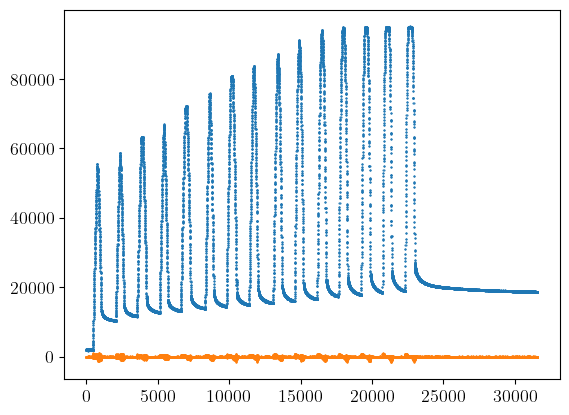

In [16]:
plt.plot(petg_y_data, ".", markersize=1)
plt.plot(np.gradient(petg_y_data), ".", markersize=1)

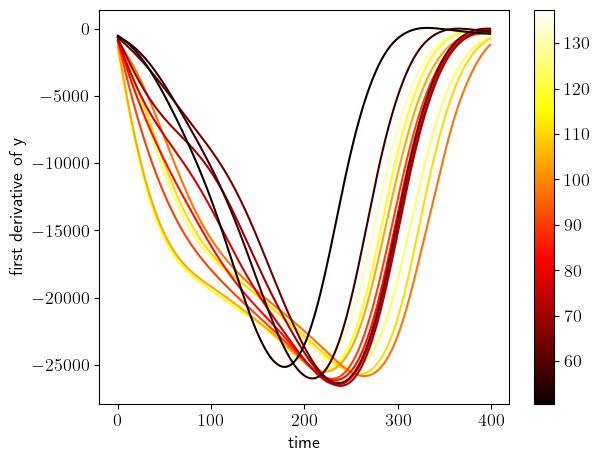

In [17]:
norm = mpl.colors.Normalize(
    vmin=min(petg_shaft_d_per_eps), vmax=max(petg_shaft_d_per_eps)
)
cmap = cm.hot
m = cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure()
for idx, data in enumerate(petg_eps_grad_data):
    d = petg_shaft_d_per_eps[idx]
    plt.plot(
        [data*d for data in data][:400],
        label=f"{d:.2f}",
        color=m.to_rgba(d),
    )

plt.rcParams['text.usetex'] = True
plt.gca().set_xlabel("time")
plt.gca().set_ylabel("first derivative of y")
plt.colorbar(m, ax=plt.gca())
plt.tight_layout()
plt.savefig("../../reports/ros_integration/figures/pteg_episodes.png")

# max_grad_per_episode = [np.min(x) for x in episodes_grad_data]
# print(shaft_distance_per_episode)
# print(max_grad_per_episode)

# fig = plt.figure()

# norm = mpl.colors.Normalize(
#     vmin=10, vmax=20
# )
# cmap = cm.hot
# m = cm.ScalarMappable(norm=norm, cmap=cmap)

# print(list([len(x) for x in episodes_grad_data]))


# for n in range(10,11):
#     nth_grad_per_episode = [x[min(n, len(x)-1)] for x in episodes_grad_data]
#     zipped_nth_grad_per_episode = zip(nth_grad_per_episode,shaft_distance_per_episode.copy())

#     zipped_nth_grad_per_episode = sorted(zipped_nth_grad_per_episode, key=lambda x: x[1])

#     plt.plot([x/d for x,d in zipped_nth_grad_per_episode], [d for _,d in zipped_nth_grad_per_episode], ".", color=m.to_rgba(n))



# episodes_data, episodes_grad_data, shaft_distance_per_episode

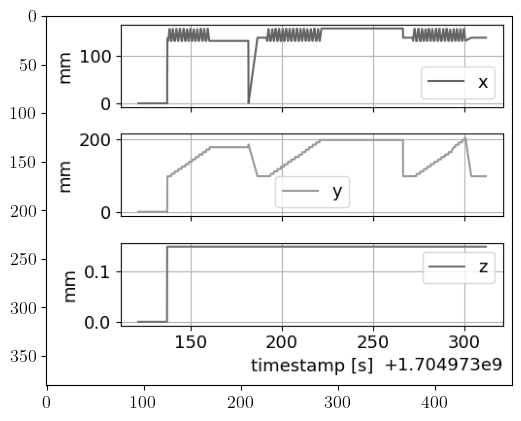

In [18]:
import cv2

# plt.savefig(output_dir / "3d_printer_raw.png")
img = cv2.imread(str(output_dir / "3d_printer_raw.png"))

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cmap="gray")